# SECTION 05
## 타이타닉 생존율 예측 모형을 위한 데이터 전처리

캐글(Kaggle.com)에서 제공하는 타이타닉 데이터에 전처리를 적용해 다양한 머신러닝 방법론에 적용해볼 수 있도록 한다. 먼저 엑셀 파일을 읽어와서 분석에서 사용하지 않을 'boat', 'body', 'home.dest' 열을 삭제한 데이터프레임을 만든 후 학습용과 테스트용 데이터로 나눈다. 그리고 학습용 데이터를 확인해보자.

In [4]:
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

In [5]:
titanic_url = 'https://github.com/sehakflower/data/blob/main/titanic_1309.xlsx?raw=true'

titanic = pd.read_excel(titanic_url, sheet_name = 'total')
train_1000 = titanic.iloc[:1000]
test_309 = titanic.iloc[1000:]

''' inplace=True(원본 데이터 직접 수정) - 경고메세지 출력됨 '''
train_1000.drop(['boat', 'body', 'home.dest'], axis = 1, inplace = True)
test_309.drop(['boat', 'body', 'home.dest'], axis = 1, inplace = True)

train_df = train_1000
test_df = test_309
train_df

C:\Users\kang\AppData\Local\Temp\ipykernel_6612\2723070382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1000.drop(['boat', 'body', 'home.dest'], axis = 1, inplace = True)
C:\Users\kang\AppData\Local\Temp\ipykernel_6612\2723070382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_309.drop(['boat', 'body', 'home.dest'], axis = 1, inplace = True)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...,...
995,3,0,"Markoff, Mr. Marin",male,35.0000,0,0,349213,7.8958,NaN,C
996,3,0,"Markun, Mr. Johann",male,33.0000,0,0,349257,7.8958,NaN,S
997,3,1,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
998,3,0,"Matinoff, Mr. Nicola",male,NaN,0,0,349255,7.8958,NaN,C


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1000 non-null   int64  
 1   survived  1000 non-null   int64  
 2   name      1000 non-null   object 
 3   sex       1000 non-null   object 
 4   age       861 non-null    float64
 5   sibsp     1000 non-null   int64  
 6   parch     1000 non-null   int64  
 7   ticket    1000 non-null   object 
 8   fare      1000 non-null   float64
 9   cabin     283 non-null    object 
 10  embarked  998 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 86.1+ KB


학습용 데이터인 train_df는 총 1,000개 레코드로 이루어져 있으며 11개 특징 중 실수형 2개, 정수형 4개, 문자형 5개로 구성되어 있다. 우리가 예측하려는 타깃 변수는 생존 여부를 나타내는 survived열이다.

titanic_df와 비교했을 때 ticket, cabin, embarked 열이 추가되었다. 누락된 값이 있는데 데이터 분석을 위해 모두 숫자형으로 바꿔야 한다. 어떤 특징은 범위가 매우 넓어서 대략 비슷하게 조절할 필요가 있다. 결측값(NaN)도 다루어야 하고 age와 cabin 정보는 많이 유실되었다. 특히 선실 번호를 나타내는 cabin은 결측치가 많아 전체 열을 생략할 수도 있다.
지금부터 각 열에 대한 전처리를 해보자.

### name 열
가장 먼저 확인할 것은 name 열이다. 이름으로 사람의 생존 여부를 판단하지는 못한다. 하지만 이름에는 남성과 여성을 나타내는 Mr, Miss, Mrs와 같은 중요한 정보가 담겨 있다. 학습용 데이터와 테스트용 데이터의 이름에서 이 정보만 추출한다.

In [7]:
total = [train_df, test_df]

for dataset in total:
    dataset['title'] = dataset['name'].str.extract(r'([A-Za-z]+)\.', expand = False)

train_df['title'].unique()

C:\Users\kang\AppData\Local\Temp\ipykernel_6612\1319213142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['name'].str.extract(r'([A-Za-z]+)\.', expand = False)
C:\Users\kang\AppData\Local\Temp\ipykernel_6612\1319213142.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['name'].str.extract(r'([A-Za-z]+)\.', expand = False)


array(['Miss', 'Master', 'Mr', 'Mrs', 'Col', 'Mme', 'Dr', 'Major', 'Capt',
       'Lady', 'Sir', 'Mlle', 'Dona', 'Jonkheer', 'Countess', 'Don',
       'Rev', 'Ms'], dtype=object)

각 호칭에 따라 5개 그룹으로 매핑해보자. 남자는 1, 아가씨는 2, 부인은 3, Master는 4, 고위직은 5로 구분한다.

In [8]:
title_mapping = {'Mr':1, 'Miss':2, 'Ms':2, 'Mlle':2, 'Mrs':3, 'Mme':3, 'Master':4, 
                 'Dr':5, 'Rev':5, 'Col': 5, 'Major':5, 'Lady':5, 'Capt':5, 
                 'Sir':5, 'Don':5, 'Jonkheer':5, 'Countess':5}

for dataset in total:
    dataset['title'] = dataset['title'].map(title_mapping)

train_df['title'].unique()

C:\Users\kang\AppData\Local\Temp\ipykernel_6612\6674719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['title'].map(title_mapping)
C:\Users\kang\AppData\Local\Temp\ipykernel_6612\6674719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['title'].map(title_mapping)


array([ 2.,  4.,  1.,  3.,  5., nan])

이것을 응용해 5개 그룹으로 만든다. name 열은 지우고 title 열을 사용한다.

In [9]:
# 5개 그룹으로 만들기
total = [train_df, test_df]
titles = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Special': 5}

for dataset in total:
    dataset['title'] = dataset['name'].str.extract(r'([A-Za-z]+)\.', expand = False)
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess', 'Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 'Rev',
                                                 'Sir', 'Jonkheer', 'Dona'], 'Special'
                                               )
    dataset['title']  = dataset['title'].replace('Mlle', 'Miss')
    dataset['title']  = dataset['title'].replace('Ms', 'Miss')
    dataset['title']  = dataset['title'].replace('Mme', 'Mrs')
    dataset['title']  = dataset['title'].map(titles) # 타이틀을 숫자로 변경
    dataset['title']  = dataset['title'].fillna('0').infer_objects(copy=False) # NaN을 0으로 변경

total

C:\Users\kang\AppData\Local\Temp\ipykernel_6612\1966775626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['name'].str.extract(r'([A-Za-z]+)\.', expand = False)
C:\Users\kang\AppData\Local\Temp\ipykernel_6612\1966775626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['title'] = dataset['title'].replace(['Lady', 'Countess', 'Capt', 'Col',
C:\Users\kang\AppData\Local\Temp\ipykernel_6612\1966775626.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[     pclass  survived                                             name  \
 0         1         1                    Allen, Miss. Elisabeth Walton   
 1         1         1                   Allison, Master. Hudson Trevor   
 2         1         0                     Allison, Miss. Helen Loraine   
 3         1         0             Allison, Mr. Hudson Joshua Creighton   
 4         1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
 ..      ...       ...                                              ...   
 995       3         0                               Markoff, Mr. Marin   
 996       3         0                               Markun, Mr. Johann   
 997       3         1                          Masselmani, Mrs. Fatima   
 998       3         0                             Matinoff, Mr. Nicola   
 999       3         1                McCarthy, Miss. Catherine "Katie"   
 
         sex      age  sibsp  parch  ticket      fare    cabin embarked  title  
 0    female  29.

In [10]:
train_df = train_df.drop(['name'], axis = 1)
test_df = test_df.drop(['name'], axis = 1)
test_df

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
1000,3,1,male,NaN,0,0,367228,7.7500,NaN,Q,1
1001,3,1,female,NaN,2,0,367226,23.2500,NaN,Q,2
1002,3,1,female,NaN,2,0,367226,23.2500,NaN,Q,2
1003,3,1,male,NaN,2,0,367226,23.2500,NaN,Q,1
1004,3,1,female,NaN,0,0,330932,7.7875,NaN,Q,2
...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,female,14.5,1,0,2665,14.4542,NaN,C,2
1305,3,0,female,NaN,1,0,2665,14.4542,NaN,C,2
1306,3,0,male,26.5,0,0,2656,7.2250,NaN,C,1
1307,3,0,male,27.0,0,0,2670,7.2250,NaN,C,1


### age 열
age 열은 중간 중간 값이 누락되어 있다. age 열의 결측치에 값을 채우는 가장 기본적인 방법으로는 나머지 모든 사람의 평균 나이를 구해서 채우는 것이다. 그런데 title 열의 그룹별로 평균 나이를 채우면 전체를 기준으로 평균 나이를 채우는 것보다 좀 더 나을 것이다. 여기서는 결측치에 각 계급의 중앙값을 채운다.

In [11]:
"""
이 코드는 test_df의 결측값을 train_df의 title별 나이 중앙값으로 채우려는 의도인데요,
train_df.groupby('title')['age'].transform('median')의 결과는 train_df와 같은 인덱스를 가진 Series예요.
즉, test_df['age']에 들어갈 수 있는 형태가 아니고, 인덱스 mismatch 때문에 NaN으로 채워져요.
"""

# title별 중앙값 딕셔너리 만들기
title_age_median = train_df.groupby('title')['age'].median()

# train_df의 age 결측치를 title 기반으로 채우기
train_df['age'] = train_df['age'].fillna(train_df['title'].map(title_age_median))

# title별 중앙값 딕셔너리 만들기
title_age_median = test_df.groupby('title')['age'].median()

# test_df의 age 결측치를 title 기반으로 채우기
test_df['age'] = test_df['age'].fillna(test_df['title'].map(title_age_median))
test_df['age']

1000    25.75
1001    18.00
1002    18.00
1003    25.75
1004    18.00
        ...  
1304    14.50
1305    18.00
1306    26.50
1307    27.00
1308    29.00
Name: age, Length: 309, dtype: float64

age 열의 전처리 결과를 시각화해서 살펴보자. 시각화를 위해 여기서는 matplotlib, seaborn 라이브러리를 이용한다.

In [12]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns

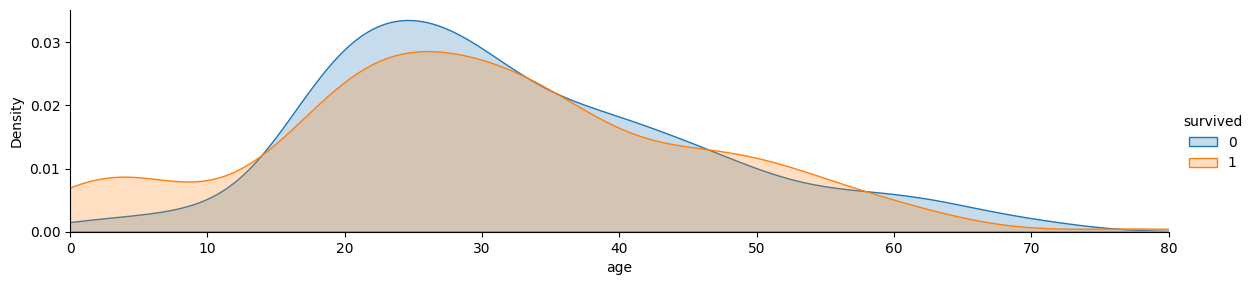

In [13]:
facet = sns.FacetGrid(train_1000, hue = "survived", aspect = 4)
facet.map(sns.kdeplot, 'age', fill = True)
facet.set(xlim = (0, train_1000['age'].max()))
facet.add_legend()
sns.axes_style("darkgrid")
plt.show()

age 열을 나이대별로 구분해보자.

In [14]:
data = [train_df, test_df]

for dataset1 in data:
    dataset1['age'] = dataset1['age'].astype(int)
    dataset1.loc[dataset1['age'] <= 11, 'age'] = 0
    dataset1.loc[(dataset1['age'] > 11) & (dataset1['age'] <= 18), 'age'] = 1
    dataset1.loc[(dataset1['age'] > 18) & (dataset1['age'] <= 22), 'age'] = 2
    dataset1.loc[(dataset1['age'] > 22) & (dataset1['age'] <= 27), 'age'] = 3
    dataset1.loc[(dataset1['age'] > 27) & (dataset1['age'] <= 33), 'age'] = 4
    dataset1.loc[(dataset1['age'] > 33) & (dataset1['age'] <= 40), 'age'] = 5
    dataset1.loc[dataset1['age'] > 40, 'age'] = 6

train_df['age'].value_counts()

age
4    242
6    206
3    141
5    141
2    126
1     80
0     64
Name: count, dtype: int64

### sex 열
성별을 나타내는 열로 male은 0, female은 1로 변환시키고 문자를 숫자로 변환시킨다.

In [15]:
sex_mapping = {'male': 0 ,'female' : 1}

for dataset in data:
    dataset['sex'] = dataset['sex'].map(sex_mapping)
    
train_df

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
0,1,1,1,4,0,0,24160,211.3375,B5,S,2
1,1,1,0,0,1,2,113781,151.5500,C22 C26,S,4
2,1,0,1,0,1,2,113781,151.5500,C22 C26,S,2
3,1,0,0,4,1,2,113781,151.5500,C22 C26,S,1
4,1,0,1,3,1,2,113781,151.5500,C22 C26,S,3
...,...,...,...,...,...,...,...,...,...,...,...
995,3,0,0,5,0,0,349213,7.8958,NaN,C,1
996,3,0,0,4,0,0,349257,7.8958,NaN,S,1
997,3,1,1,5,0,0,2649,7.2250,NaN,C,3
998,3,0,0,4,0,0,349255,7.8958,NaN,C,1


### embarked, pclass 열
승선 도시별로 부유한 사람과 가난한 사람의 생존율 차이가 있는지 확인하기 위해 승객 등급 비율을 알아본다.

<Axes: >

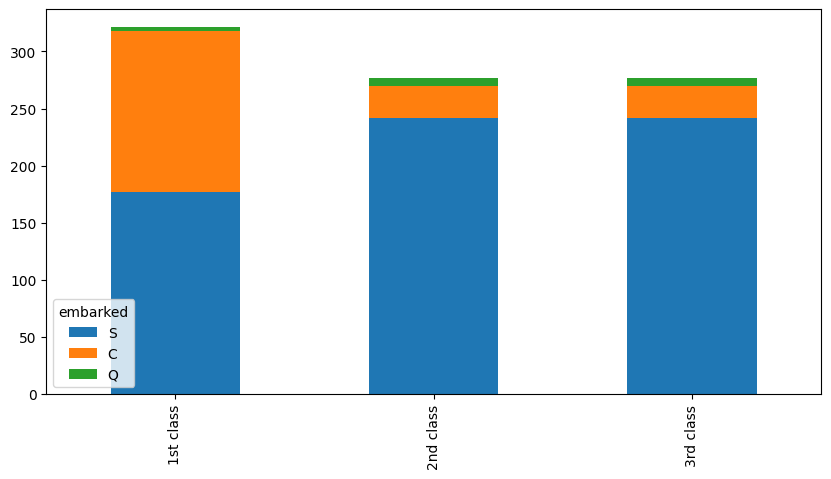

In [16]:
pclass1 = train_df[train_df['pclass'] == 1]['embarked'].value_counts()
pclass2 = train_df[train_df['pclass'] == 2]['embarked'].value_counts()
pclass3 = train_df[train_df['pclass'] == 3]['embarked'].value_counts()

df = pd.DataFrame([pclass1, pclass2, pclass2])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind = 'bar', stacked = True, figsize = (10, 5))

embarked 열의 값 중에서 C는 프랑스의 셰르부르, Q는 뉴질랜드의 퀸즈타운, S는 영국의 사우스햄튼을 나타낸다. 결과를 보면, 1등급 승객 중에서 퀸즈타운(Q)에서 승선한 승객은 거의 없고 대부분 셰르부르(C)에서 승선했다. embarked 정보가 누락되었다면 결측치 대신 S를 채워도 괜찮을 것이다.

In [17]:
for dataset in data:
    dataset['embarked'] = dataset['embarked'].fillna('S')
len(train_df['embarked'].isnull())

1000

결측치가 없는 것을 확인했으니 머신러닝 분류를 위해 문자를 숫자로 바꿔보자. 'S':0, 'C':1, 'Q':2 로 바꾼다

In [18]:
embarked_mapping = {'S' : 0, 'C' : 1, 'Q' : 2}
for dataset in data:
    dataset['embarked'] = dataset['embarked'].map(embarked_mapping)

train_df['embarked']

0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    0
997    1
998    1
999    2
Name: embarked, Length: 1000, dtype: int64

pclass 열을 살펴보자. train_df['pclass'].dtype을 실행하면 dtype('int64')이 출력되어 정수형임을 알 수 있다. 즉, 전처리를 할 필요가 없다.

### sibsp, patch 열
혼자 여행하는 경우와 가족과 함께 여행하는 경우의 생존율이 어떻게 다른지 살펴보자. dataset['sibsp']+dataset['patch']처럼 두 열의 데이터를 더해 새로운 열인 sibpar를 생성한다. 이 값이 0보다 크면 혼자가 아님을 나타내는 n_alone열에 0을 넣고 0이면 1을 넣는다. 그리고 n_alone열을 정수형으로 변경한다.

In [19]:
# SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수
# Parch : 동반한 Parent(부모) Child(자식)의 수

data = [train_df, test_df]

for dataset in data:
    dataset['sibpar'] = dataset['sibsp'] + dataset['parch']
    dataset.loc[dataset['sibpar'] > 0, 'n_alone'] = 0
    dataset.loc[dataset['sibpar'] == 0, 'n_alone'] = 1
    dataset['n_alone'] = dataset['n_alone'].astype(int)
test_df

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,sibpar,n_alone
1000,3,1,0,3,0,0,367228,7.7500,NaN,2,1,0,1
1001,3,1,1,1,2,0,367226,23.2500,NaN,2,2,2,0
1002,3,1,1,1,2,0,367226,23.2500,NaN,2,2,2,0
1003,3,1,0,3,2,0,367226,23.2500,NaN,2,1,2,0
1004,3,1,1,1,0,0,330932,7.7875,NaN,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,1,1,1,0,2665,14.4542,NaN,1,2,1,0
1305,3,0,1,1,1,0,2665,14.4542,NaN,1,2,1,0
1306,3,0,0,3,0,0,2656,7.2250,NaN,1,1,0,1
1307,3,0,0,3,0,0,2670,7.2250,NaN,1,1,0,1


학습용 데이터와 테스트용 데이터에서 혼자 여행한 승객과 동반 여행한 승객을 세어보면 다음과 같다.

In [20]:
train_df['n_alone'].value_counts()

n_alone
1    584
0    416
Name: count, dtype: int64

In [21]:
test_df['n_alone'].value_counts()

n_alone
1    206
0    103
Name: count, dtype: int64

### cabin열
cabin 열의 값을 보면 알파벳+숫자 또는 알파벳으로 이루어져 있다.

In [22]:
# Cabin : 객실 번호
train_df.cabin.value_counts()

cabin
C23 C25 C27        6
B57 B59 B63 B66    5
C22 C26            4
B96 B98            4
C78                4
                  ..
E77                1
D38                1
F                  1
F E57              1
F E46              1
Name: count, Length: 180, dtype: int64

cabin 열 값의 맨 앞 영문자만 추출한다.

In [23]:
for dataset in data:
    dataset['cabin'] = dataset['cabin'].str[:1]
train_df.cabin.value_counts()

cabin
C    94
B    65
D    46
E    38
A    22
F    17
T     1
Name: count, dtype: int64

승객 등급별로 어떤 객실을 사용하는지 확인해보자.

<Axes: >

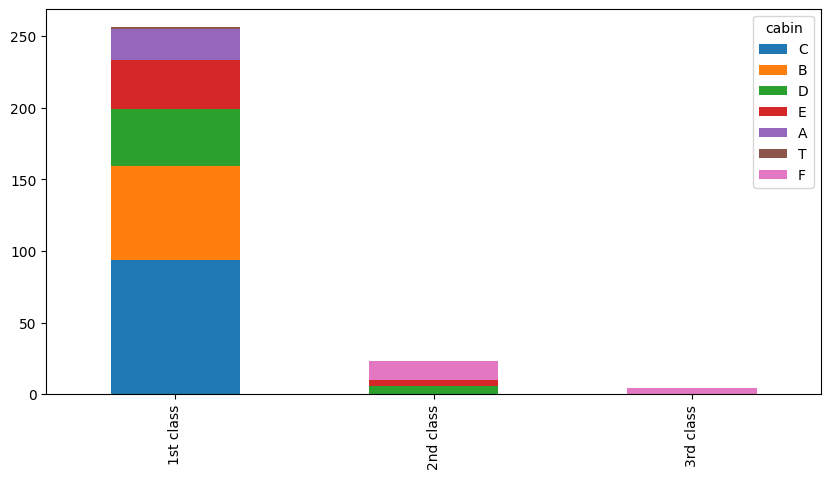

In [24]:
pclass1 = train_df[train_df['pclass'] == 1]['cabin'].value_counts()
pclass2 = train_df[train_df['pclass'] == 2]['cabin'].value_counts()
pclass3 = train_df[train_df['pclass'] == 3]['cabin'].value_counts()

df = pd.DataFrame([pclass1, pclass2, pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind = 'bar', stacked = True, figsize = (10, 5))

1등급은 ABCDET, 2등급은 DEF, 3등급은 EFG로 구성되어 있음을 알 수 있다. 그러나 1,000개의 학습용 데이터 중에서 283개만 값이 있고 나머지는 결측치이므로 이 열은 사용하지 않겠다. 지금까지 전처리한 것 중에서 name, sex, embarked 열은 카테고리 변수로 데이터 분석에 사용할 계획이다. 그리고 티켓 번호를 나타내는 ticket 열의 값은 생존율과 관계가 없으니 분석에서 고려하지 않는다.

### fare 열
티켓 가격은 승객 등급과 관련이 높다. fare 열에 결측치가 있으면 각 등급별 티켓 가격의 중앙값을 결측치 대신 넣어준다. 또한 fare 열을 편의상 최댓값과 최솟값을 감안한 5개 구간으로 나누어 본다.

In [25]:
# Fare : 티켓의 요금
pclass_fare_median = train_df.groupby('pclass')['fare'].median()
train_df['fare'] = train_df['fare'].fillna(train_df['pclass'].map(pclass_fare_median))

pclass_fare_median = test_df.groupby('pclass')['fare'].median()
test_df['fare'] = test_df['fare'].fillna(test_df['pclass'].map(pclass_fare_median))


for dataset in data:
    dataset.loc[dataset['fare'] <= 20, 'fare'] = 1
    dataset.loc[(dataset['fare'] > 20) & (dataset['fare'] <= 30), 'fare'] = 2
    dataset.loc[(dataset['fare'] > 30) & (dataset['fare'] <= 50), 'fare'] = 3
    dataset.loc[(dataset['fare'] > 50) & (dataset['fare'] <= 100), 'fare'] = 4
    dataset.loc[dataset['fare'] > 100, 'fare'] = 5

train_df

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,sibpar,n_alone
0,1,1,1,4,0,0,24160,5.0,B,0,2,0,1
1,1,1,0,0,1,2,113781,5.0,C,0,4,3,0
2,1,0,1,0,1,2,113781,5.0,C,0,2,3,0
3,1,0,0,4,1,2,113781,5.0,C,0,1,3,0
4,1,0,1,3,1,2,113781,5.0,C,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0,0,5,0,0,349213,1.0,NaN,1,1,0,1
996,3,0,0,4,0,0,349257,1.0,NaN,0,1,0,1
997,3,1,1,5,0,0,2649,1.0,NaN,1,3,0,1
998,3,0,0,4,0,0,349255,1.0,NaN,1,1,0,1


### 열 추가하기: 개인별 요금을 나타내는 fare_person
개인별 티켓 요금을 계산하기 위해 요금을 동반자 수로 나누고 새로 만든 fare_person 열에 정수 형태로 저장하자.

In [26]:
if (train_df['sibpar'] < 0).any():
    print("음수 sibpar 값 있음!")
else:
    print("음수 sibpar 값 없음")
    
train_df['fare'].isna().any()

음수 sibpar 값 없음


np.False_

In [27]:
for dataset1 in data:
    dataset1['fare_person'] = dataset1['fare']/(dataset1['sibpar'] + 1)
    dataset1['fare_person'] = dataset1['fare_person'].astype(int)
train_df

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,sibpar,n_alone,fare_person
0,1,1,1,4,0,0,24160,5.0,B,0,2,0,1,5
1,1,1,0,0,1,2,113781,5.0,C,0,4,3,0,1
2,1,0,1,0,1,2,113781,5.0,C,0,2,3,0,1
3,1,0,0,4,1,2,113781,5.0,C,0,1,3,0,1
4,1,0,1,3,1,2,113781,5.0,C,0,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,0,0,5,0,0,349213,1.0,NaN,1,1,0,1,1
996,3,0,0,4,0,0,349257,1.0,NaN,0,1,0,1,1
997,3,1,1,5,0,0,2649,1.0,NaN,1,3,0,1,1
998,3,0,0,4,0,0,349255,1.0,NaN,1,1,0,1,1


### 최종 데이터
전처리가 끝났으니 분석에 사용할 데이터를 학습용 데이터와 테스트용 데이터로 만들어본다. 다음은 학습용 데이터를 독립변수와 종속변수의 2개 데이터프레임으로 나눈 것이다.

In [28]:
X_columns = ['pclass', 'sex', 'age', 'embarked', 'title',
            'sibpar', 'n_alone', 'fare_person']
y_columns = ['survived']
X_train = train_df[X_columns]
y_train = train_df[y_columns]
y_train
X_train

,pclass,sex,age,embarked,title,sibpar,n_alone,fare_person
0,1,1,4,0,2,0,1,5
1,1,0,0,0,4,3,0,1
2,1,1,0,0,2,3,0,1
3,1,0,4,0,1,3,0,1
4,1,1,3,0,3,3,0,1
...,...,...,...,...,...,...,...,...
995,3,0,5,1,1,0,1,1
996,3,0,4,0,1,0,1,1
997,3,1,5,1,3,0,1,1
998,3,0,4,1,1,0,1,1


테스트용 데이터도 다음과 같이 나누었다.

In [29]:
X_columns = ['pclass', 'sex', 'age', 'embarked', 'title',
             'sibpar', 'n_alone', 'fare_person']
y_columns = ['survived']
X_test = test_df[X_columns]
y_test = test_df[y_columns]
X_test
y_test

,survived
1000,1
1001,1
1002,1
1003,1
1004,1
...,...
1304,0
1305,0
1306,0
1307,0


여기에서 만든 학습용 데이터와 테스트용 데이터는 10장 3절의 데이터 분석에서 사용된다.